# Test 0: How much does HRRR matter, really?
We'll train a model with AirNow data only. All the preprocessing should already be done for us.

## AirNow preprocessing

In [1]:
# define bounding box
lat_bottom, lat_top = 33.9, 34.2
lon_bottom, lon_top = -118.4, -118.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 200
frames_per_sample = 5

# date range of data
start_date, end_date = "2025-01-10-00", "2025-01-17-00"

In [2]:
# python nonsense that allows you to import from sibling directories
import sys
sys.path.append("..")

In [3]:
from libs.airnowdata import AirNowData
AD = AirNowData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    airnow_api_key=None,
    save_dir='../data/airnow.json',
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../data/interpolation/elevation.npy",
    mask_path="../data/interpolation/mask.npy"
)

'../data/airnow.json' already exists; skipping request...


In [4]:
X_airnow = AD.data
Y = AD.target_stations
print(X_airnow.shape)
print(Y.shape)

(165, 5, 200, 200, 1)
(165, 3)


## Joint preprocessing
- Split into train/test sets
- Scale train/test sets independently
- Combine X datasets into 1 with 2 channels

In [5]:
# split data
def train_test_split(X, train_size=0.75):
    split_idx = int(X.shape[0] * train_size)
    X_train, X_test = X[:split_idx], X[split_idx:]
    
    return X_train, X_test

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

In [6]:
import numpy as np

# split data
X_airnow_train, X_airnow_test = train_test_split(X_airnow, train_size=0.75)
y_train, y_test = train_test_split(Y, train_size=0.75)

# scale training data, then test data based on training data's stats
X_train, X_test = std_scale(X_airnow_train, X_airnow_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(123, 5, 200, 200, 1) (42, 5, 200, 200, 1)
(123, 3) (42, 3)


## Final input viz

Displaying frames for example 102.


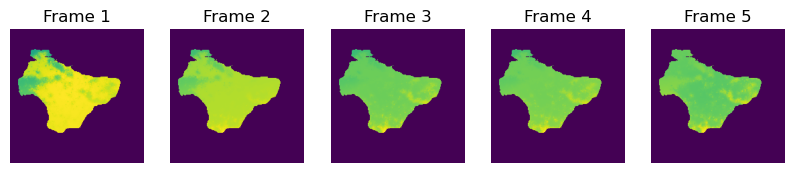

Target:  [11.1 11.2 19.7]


In [7]:
import matplotlib.pyplot as plt

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 5, figsize=(10, 4))

# Plot each of the sequential images for one random data example.
# plot hrrr channel
np.random.seed(42)
rand_sample = np.random.choice(range(len(X_train)), size=1)[0]
for idx, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {rand_sample}.")
plt.show()

print("Target: ", y_train[rand_sample])

## Model

In [8]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

2025-04-17 15:29:16.183028: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 15:29:16.190907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744928956.202110   36638 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744928956.205530   36638 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 15:29:16.215698: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [9]:
print(X_airnow_train.shape, X_airnow_test.shape, y_train.shape, y_test.shape)

(123, 5, 200, 200, 1) (42, 5, 200, 200, 1) (123, 3) (42, 3)


In [10]:
tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=(5, 200, 200, 1))
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())

seq.add(Dense(3,activation='relu'))

seq.compile(loss='mean_absolute_error', optimizer='adam')
seq.summary()

I0000 00:00:1744928957.399131   36638 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6421 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 200, 200,    │         8,700 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 200, 200,    │        48,720 │
│                                 │ 30)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 200, 200,    │        12,165 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 200, 200, 1) │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       600,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,994 (2.56 MB)

 Trainable params: 669,994 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
seq.fit(X_airnow_train, y_train, batch_size=4, epochs=150)

Epoch 1/150


I0000 00:00:1744928959.962547   36997 service.cc:148] XLA service 0x580eeaac48e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744928959.962568   36997 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-04-17 15:29:20.043609: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744928960.310466   36997 cuda_dnn.cc:529] Loaded cuDNN version 90800
E0000 00:00:1744928960.868368   36997 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744928961.046366   36997 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744928961.384786  

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 15.8368

E0000 00:00:1744928971.218712   36996 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744928971.397499   36996 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744928971.730638   36996 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744928971.907183   36996 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744928972.464808   36996 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 327ms/step - loss: 15.6272
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 8.8104
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 8.1415
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 7.7184
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 5.6523
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 5.7610
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 5.3398
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 5.6276
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 5.3411
Epoch 10/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 4.8021
Epoch 11/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 4.6029
Epoch 12/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 4.1560
Epoch 13/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 4.0401
Epoch 14/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 5.9516
Epoch 15/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

## Results

In [12]:
y_pred = seq.predict(X_airnow_test, verbose=0)

2025-04-17 15:41:17.295122: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,15,200,200]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,200,200]{3,2,1,0}, f32[15,1,3,3]{3,2,1,0}, f32[15]{0}, f32[32,15,200,200]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-17 15:41:17.741403: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,200,200]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,200,200]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,200,200]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_label

In [13]:
from skimage.metrics import mean_squared_error as mse

def rmse(y_pred, y_test):
    return np.sqrt(mse(y_pred, y_test))

def nrmse(y_pred, y_test):
    return rmse(y_pred, y_test) / np.mean(y_test) * 100
    
print("Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data")
print("Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) \n")

print("RESULTS")
print("---------------------------------------------------------------------------")
print(f"All Days All Locations - y_pred vs y_test Raw RMSE: {rmse(y_pred, y_test):.2f}")
print(f"All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: {nrmse(y_pred, y_test):.2f}%\n")

print("RESULTS BY FRAME")
print("---------------------------------------------------------------------------")
for i in range(5):
    print(f"Frame {i+1} (Hour {i+1}) All Locations - Raw RMSE: {rmse(y_pred[i,:], y_test[i,:]):.2f}")
    print(f"Frame {i+1} (Hour {i+1}) All Locations - RMSE Percent Error of Mean: {nrmse(y_pred[i,:], y_test[i,:]):.2f}%\n")

print("RESULTS BY SENSOR LOCATION")
print("---------------------------------------------------------------------------")
for i, loc in enumerate(list(AD.air_sens_loc.keys())):
    print(f"All Days - {loc} Raw RMSE: {rmse(y_pred[:,i], y_test[:,i]):.2f}")
    print(f"All Days - {loc} RMSE Percent Error of Mean: {nrmse(y_pred[:,i], y_test[:,i]):.2f}%\n")

Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data
Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) 

RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 3.45
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 31.35%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 2.82
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 18.28%

Frame 2 (Hour 2) All Locations - Raw RMSE: 4.93
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 35.82%

Frame 3 (Hour 3) All Locations - Raw RMSE: 7.20
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 52.31%

Frame 4 (Hour 4) All Locations - Raw RMSE: 3.22
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 22.71%

Frame 5 (Hour 5) All Locations 

## Visualization

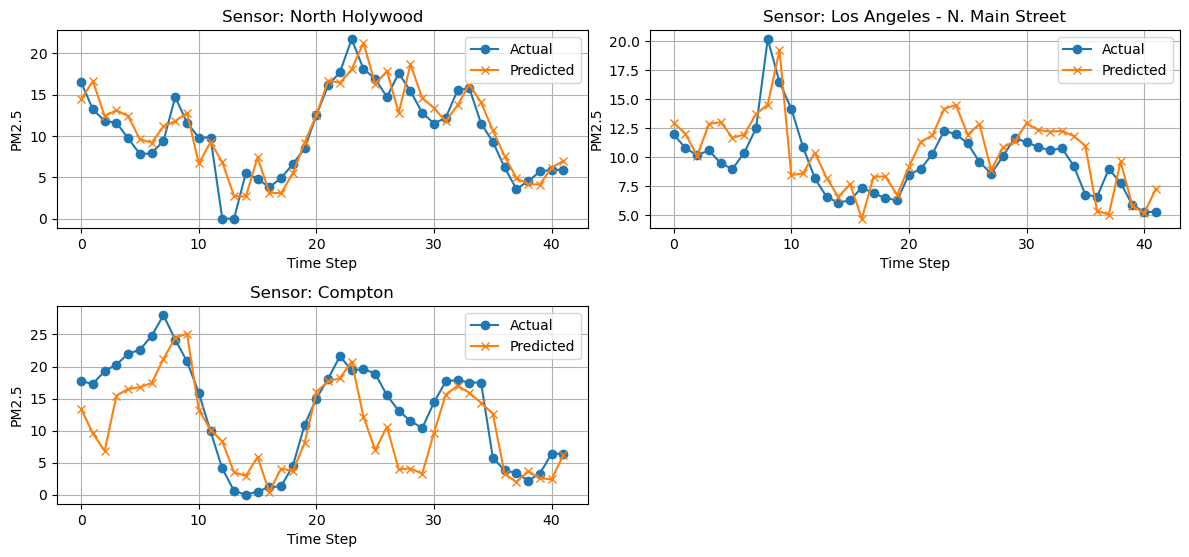

In [14]:
plt.figure(figsize=(12, 8))
for i, sensor in enumerate(AD.air_sens_loc.keys()):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual', marker='o')
    plt.plot(y_pred[:, i], label='Predicted', marker='x')
    plt.title(f'Sensor: {sensor}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()